# Исследование прибыли добывающей компании<a class="tocSkip">
<a id="start"></a>

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Регион-0" data-toc-modified-id="Регион-0-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Регион 0</a></span></li><li><span><a href="#Регион-1" data-toc-modified-id="Регион-1-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Регион 1</a></span></li><li><span><a href="#Регион-2" data-toc-modified-id="Регион-2-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Регион 2</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Обучение-лучшей-модели" data-toc-modified-id="Обучение-лучшей-модели-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Обучение лучшей модели</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Описание проекта
### Записка к данным <a class="tocSkip">

Добывающей компании нужно выбрать наиболее перспективный регион для развития. Шаги для выбора локации, как правило, такие:

1. В избранном регионе собирают характеристики скважин: качество нефти и объём её запасов
2. Строят модель для предсказания объёма запасов в новых скважинах
3. Выбирают скважины с самыми высокими оценками значений
4. Определяют регион с максимальной суммарной прибылью отобранных скважин




Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль, и проанализировать возможные риски. Для компании важно, чтобы предсказания модели были интерпретируемы.

Данные для расчётов:
* При разведке региона исследуют 500 скважин, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Объём указан в тысячах баррелей.
* Вероятность убытков компании при развитии региона должна быть меньше 2.5%. Из регионов, удовлетворяющих этому условию, выбирают регион с наибольшей средней прибылью.

In [1]:
WELLS_TO_EXPLORE_PER_REGION = 500
WELLS_TO_MINE_PER_REGION = 200
COSTS = 1e10
REVENUE_PER_THSD_BARREL = 4.5e5
LOSS_PROBABILITY = 2.5e-2

___
Перед началом анализа импортируем необходимые библиотеки и создадим несколько функций.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from itertools import combinations

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.utils import shuffle

from sklearn.linear_model import Ridge, Lasso
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = None
%matplotlib inline

In [4]:
def plot_kde(data_list, xlabels, title=None, xlims=None, figsize=(15,5)):
    fig, axes = plt.subplots(ncols=len(data_list), figsize=figsize) 
    plt.subplots_adjust(wspace=0.3)
    colors = ['lightsalmon', 'tomato', 'firebrick']
    if title:
        plt.suptitle(title, fontsize=16)
    for i in range(len(data_list)):             
        axes[i].set_facecolor('whitesmoke')
        for j in range(len(data_list[i])):    
            data_list[i][j].plot.kde(ax=axes[i], color=colors[j], linewidth=3, label='Регион {}'.format(j),)
        axes[i].set_xlabel(xlabels[i], fontsize=14)
        axes[i].set_ylabel('Ядерная оценка плотности', fontsize=12)
        axes[i].set_ylim(0,)
        if xlims:
            axes[i].set_xlim(xlims[i])
        axes[i].grid(color='w', lw=1, axis='both')
        axes[i].xaxis.set_ticks_position('none') 
        axes[i].yaxis.set_ticks_position('none') 
        axes[i].legend(facecolor='ghostwhite', ncol=1, shadow=True, fancybox=False, loc='upper right')
    plt.show()

In [5]:
def plot_corr_matrix(data_list, figsize=(15,15)):
    fig, axes = plt.subplots(ncols=len(data_list), figsize=figsize)
    plt.subplots_adjust(wspace=0.3)
    plt.suptitle('Корреляционная матрица', fontsize=16)
    for i in range(len(data_list)):
        size = len(data_list[i])
        mask = np.triu(np.ones((size, size)), k=1)
        sns.heatmap(data_list[i], annot=True, fmt='.2f', mask=mask, square=False, 
                    vmin=-1, vmax=1, cbar=(i == 2), ax=axes[i], label='ds')
        
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)
        axes[i].xaxis.set_ticks_position('none')
        axes[i].yaxis.set_ticks_position('none')
        b, t = axes[i].set_ylim() 
        axes[i].set_ylim(b + 0.5, t - 0.5)
        axes[i].text(0.5,-0.2, 'Регион ' + str(i), ha='center', fontsize=12, transform=axes[i].transAxes)
    plt.show()

In [6]:
def plot_scatter(data_list, xlabels, ylabels, title=None, alphas=[0.01,0.01,0.01], figsize=(15,4)):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)    
    plt.subplots_adjust(wspace=0.4)
    if title:
        plt.suptitle(title, fontsize=16)    
    for i in range(len(data_list)):             
        axes[i].set_facecolor('whitesmoke')  
        x = np.array(data_list[i].dropna().iloc[:, 0])
        y = np.array(data_list[i].dropna().iloc[:, 1])
        axes[i].scatter(x, y, alpha=alphas[i], s=70,  facecolor='tomato', edgecolors='tomato')
        axes[i].set_xlabel(xlabels[i], fontsize=14)
        axes[i].set_ylabel(ylabels[i], fontsize=14)   
        axes[i].grid(color='w', lw=1, axis='both')
        axes[i].set_axisbelow(True)
        axes[i].xaxis.set_ticks_position('none')
        axes[i].yaxis.set_ticks_position('none')
    plt.show()

In [7]:
def plot_scatter_labeled(data, cols, title, alpha=0.8, figsize=(7,5)):
    fig, axes = plt.subplots(figsize=figsize)    
    plt.suptitle(title, fontsize=16)
    axes.set_facecolor('whitesmoke')
    cmap = plt.cm.get_cmap('plasma')
    n = len(data[cols[2]].unique())
    colors = ['tomato', 'mediumorchid', 'silver']*10
    for i in range(n):
        data[data[cols[2]] == data[cols[2]].unique()[i]].plot.scatter(
            ax=axes, x=cols[0], y=cols[1], color=cmap(i / n), label=str(data[cols[2]].unique()[i]),
            alpha=alpha, edgecolor='whitesmoke', lw=0.3, s=50)
    axes.legend(facecolor='ghostwhite', title=cols[2],fontsize=12, ncol=1, shadow=True, 
                fancybox=False, bbox_to_anchor=(1.2, 1))
    axes.set_xlabel(cols[0], fontsize=14)
    axes.set_ylabel(cols[1], fontsize=14)   
    axes.grid(color='w', lw=1, axis='both')
    axes.set_axisbelow(True)
    axes.xaxis.set_ticks_position('none')
    axes.yaxis.set_ticks_position('none')
    plt.show()

In [8]:
def plot_bar(data_list, xlabels, figsize=(15,15)):
    fig, axes = plt.subplots(nrows=len(data_list), figsize=figsize)    
    plt.subplots_adjust(hspace=0.4)
    for i in range(len(data_list)):              
        axes[i].set_facecolor('whitesmoke')
        data_list[i].plot.bar(ax=axes[i], color='tomato', edgecolor='indianred', lw=2, label='Регион ' + str(i))
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, fontsize=12)
        axes[i].grid(color='w', lw=1, axis='y')
        axes[i].set_axisbelow(True)
        axes[i].xaxis.set_ticks_position('none')
        axes[i].yaxis.set_ticks_position('none')
        axes[i].set_xlabel(xlabels[i], fontsize=14)
        axes[i].set_ylabel('Вес признака $|w|$', fontsize=14)
        axes[i].legend(facecolor='ghostwhite', fontsize=14, ncol=1, shadow=True, fancybox=False)
    plt.show()

In [9]:
def plot_revenue_bar(df, figsize=(15,4)):
    fig, axes = plt.subplots(figsize=figsize)    
    plt.suptitle('Ожидаемая прибыль компании', fontsize=16)    
    axes.set_facecolor('whitesmoke')
    axes.barh(['Регион ' + str(i) for i in [0,1,2]], df.iloc[1,:3], height=0.5, label='Случайные скважины', 
              color='tomato', capsize=15, xerr=[df.iloc[1,:3] - df.iloc[2,:3], df.iloc[3,:3] - df.iloc[1,:3]],
              error_kw=dict(lw=1, capsize=5))
    axes.barh(['Регион ' + str(i) for i in [0,1,2]], df.iloc[1,3:], height=0.5, label='Лучшие скважины', 
              color='coral', capsize=15, xerr=[df.iloc[1,3:] - df.iloc[2,3:], df.iloc[3,3:] - df.iloc[1,3:]],
              error_kw=dict(lw=1, capsize=5))
    axes.set_xlabel('Средняя прибыль компании, млрд. руб.', fontsize=14) 
    axes.tick_params(labelsize=12)
    axes.grid(color='w', lw=1, axis='x')
    axes.set_axisbelow(True)
    axes.xaxis.set_ticks_position('none')
    axes.yaxis.set_ticks_position('none')
    axes.legend(facecolor='ghostwhite', fontsize=12, ncol=1, shadow=True, fancybox=False)
    plt.show()

# Обзор данных 
[к оглавлению](#start)

Откроем файлы и изучим общую информацию.

In [10]:
all_data = [
    pd.read_csv('geo_data_0.csv'),
    pd.read_csv('geo_data_1.csv'),
    pd.read_csv('geo_data_2.csv')
]

In [11]:
for data in all_data:
    data.info()
    print()
all_data[0].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3

id     f0     f1    f2  product
0  txEyH  0.706 -0.498 1.221  105.280
1  2acmU  1.335 -0.340 4.365   73.038
2  409Wp  1.023  0.152 1.420   85.266
3  iJLyR -0.032  0.139 2.979  168.621
4  Xdl7t  1.988  0.155 4.752  154.037

В таблицах 5 столбцов:
* `id` — уникальный идентификатор скважины
* `f0, f1, f2` — признаки, характеризующие качество нефти (физический смысл неизвестен)
* `product` — объём запасов в скважине (тыс. баррелей)

В каждой из таблиц 100000 строк, пропуски отсутствуют. Типы данных правильные: категориальный признак `id` имеет тип `object`, остальные признаки численные, тип данных `float64`.

Индекс строк не несёт смысловой нагрузки. Строки в таблицах, похоже, никак не упорядочены. 

Выполним предобработку.

# Предобработка
[к оглавлению](#start)

### Проверка идентификаторов <a class="tocSkip">

Начнём с идентификаторов скважин. Проверим наличие повторов.

In [12]:
pd.DataFrame(
    {'Повторяющиеся id': [data['id'].duplicated().sum() for data in all_data],
        'Дубликаты': [data.duplicated().sum() for data in all_data]
    }, 
    index=['Регион ' + str(i) for i in [0,1,2]]
)

Повторяющиеся id  Дубликаты
Регион 0                10          0
Регион 1                 4          0
Регион 2                 4          0

Видим, что во всех трёх регионах есть скважины с повторяющимися id, при этом данные о качестве и объёме нефти в этих скважинах отличаются. Возможно, на этих скважинах несколько раз проводились замеры характеристик — выведем повторяющиеся строки.

In [13]:
all_data[0][all_data[0]['id'].duplicated(keep=False)].sort_values(by='id').head(10)

id     f0     f1     f2  product
66136  74z30  1.085 -0.312  6.991  127.643
64022  74z30  0.741  0.459  5.153  140.771
51970  A5aEY -0.180  0.936 -2.095   33.020
3389   A5aEY -0.040  0.157  0.210   89.249
69163  AGS9W -0.934  0.116 -3.656   19.230
42529  AGS9W  1.455 -0.480  0.683  126.371
931    HZww2  0.755  0.369  1.863   30.682
7530   HZww2  1.061 -0.374 10.430  158.829
63593  QcMuo  0.636 -0.473  0.863   64.579
1949   QcMuo  0.507 -0.324 -2.216   75.497

In [14]:
all_data[1][all_data[1]['id'].duplicated(keep=False)].sort_values(by='id')

id     f0      f1     f2  product
5849   5ltQ6 -3.435 -12.296  2.000   57.086
84461  5ltQ6 18.214   2.192  3.994  107.813
1305   LHZR0 11.171  -1.945  3.003   80.860
41906  LHZR0 -8.990  -4.287  2.009   57.086
2721   bfPNe -9.494  -5.464  4.006  110.992
82178  bfPNe -6.203  -4.820  2.995   84.039
47591  wt4Uk -9.091  -8.109 -0.002    3.179
82873  wt4Uk 10.260  -9.376  4.994  134.766

In [15]:
all_data[2][all_data[2]['id'].duplicated(keep=False)].sort_values(by='id')

id     f0     f1     f2  product
45404  KUPhW  0.232 -1.699  4.991   11.716
55967  KUPhW  1.211  3.176  5.544  132.832
11449  VF7Jo  2.123 -0.858  5.746  181.717
49564  VF7Jo -0.883  0.561  0.724  136.233
44378  Vcm5J -1.229 -2.439  1.223  137.968
95090  Vcm5J  2.588  1.987  2.482   92.328
28039  xCHr8  1.633  0.368 -2.378    6.121
43233  xCHr8 -0.847  2.102  5.597  184.389

Видим, что значения всех признаков у скважин с одинаковым id довольно сильно отличаются $\to$ маловероятно, что это результат нескольких замеров. Поскольку начения признаков кажутся вполне адекватными, будем считать, что эти данные относятся к разным скважинам.

Теперь можем удалить столбец `id`, поскольку для нашей задачи он не представляет интереса.

In [16]:
all_data = [all_data[i].drop(columns=['id']) for i in [0,1,2]]

### Деление на обучающую и тестовую выборки <a class="tocSkip">

Делим выборки в отношении 3:1

In [17]:
train_data = []
test_data = []
for data in all_data:
    train, test = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)
    train_data.append(train)
    test_data.append(test)
    print('{} объектов в обучении и {} в тесте'.format(len(train), len(test)))

75000 объектов в обучении и 25000 в тесте
75000 объектов в обучении и 25000 в тесте
75000 объектов в обучении и 25000 в тесте


Проверим качество разбиения.

In [18]:
def check_split(train_data, test_data, cat_features=None):
    train = train_data.copy()
    test = test_data.copy()
    train['is_train'] = 1
    test['is_train'] = 0
    data = shuffle(pd.concat([train, test], axis=0, ignore_index=True), random_state=42)
    x, y = data.drop(columns=['is_train']), data['is_train']
    clf = CatBoostClassifier(random_state=42, cat_features=cat_features, iterations=50, verbose=False)
    score = cross_val_score(clf, x, y, cv=3, scoring='roc_auc').mean()
    return score

In [19]:
split_scores = [check_split(train_data[i], test_data[i]) for i in [0,1,2]]
pd.DataFrame({'AUC-ROC': split_scores}, index=['Регион ' + str(i) for i in [0,1,2]])

AUC-ROC
Регион 0    0.503
Регион 1    0.500
Регион 2    0.502

Качество на уровне случайного классификатора $\to$ разбиение хорошее :)

### Предобработка численных признаков <a class="tocSkip">
    
Посмотрим на значения признаков.

In [20]:
columns = all_data[0].columns

In [21]:
pd.concat({
    'Регион '+ str(i) : train_data[i][columns].describe().loc[['min','50%','mean','max','std']] for i in [0,1,2]
}, axis=1)

Регион 0                        Регион 1                        Регион 2  \
           f0     f1      f2 product       f0      f1     f2 product       f0   
min    -1.409 -0.848 -10.138   0.000  -31.610 -26.359 -0.018   0.000   -8.760   
50%     0.503  0.252   2.526  92.185    1.164  -4.824  2.012  57.086    0.009   
mean    0.500  0.251   2.511  92.558    1.128  -4.807  2.496  68.858    0.002   
max     2.362  1.331  16.004 185.364   29.422  16.737  5.020 137.945    7.238   
std     0.872  0.504   3.249  44.293    8.964   5.118  1.703  45.944    1.731   

                             
         f1      f2 product  
min  -7.084 -11.970   0.000  
50%  -0.013   2.498  94.907  
mean -0.005   2.503  94.950  
max   7.845  16.739 190.030  
std   1.732   3.476  44.739

* Признаки неоднородны: масштабы значений в разных регионах отличаются. Например, признак `f0` в регионе 0 принимает значения из отрезка $[-1.4; 2.4],$ а в регионе 1 — из $[-31.6; 29.4]$. Стандартные отклонения отличаются на порядок.
* Области определения и разброс значений целевого признака в трёх регионах практически совпадают. При этом наибольшие средние запасы нефти в регионе 2. 

Посмотрим на распределения признаков.

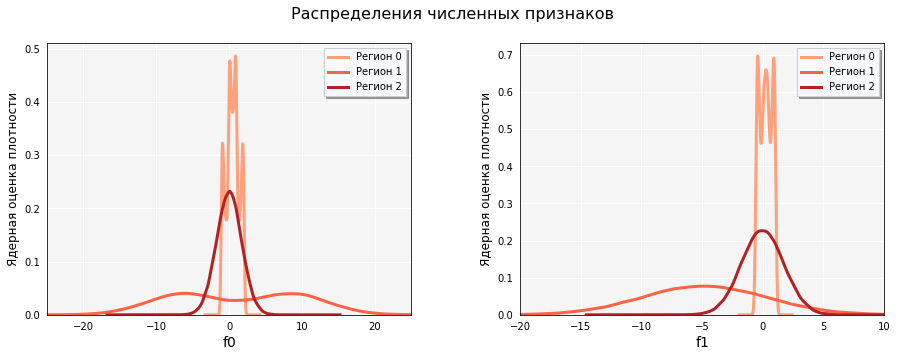

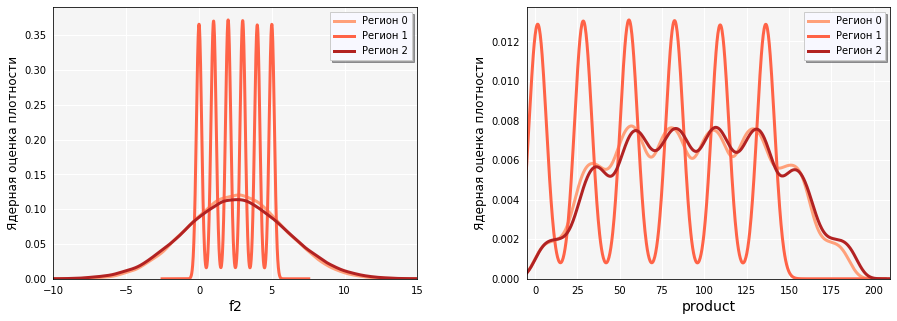

In [22]:
plot_kde(
    [[d[col] for d in train_data] for col in columns[:2]], xlabels=columns[:2], xlims=[(-25,25),(-20,10)],
    title='Распределения численных признаков'
)
plot_kde(
    [[d[col] for d in train_data] for col in columns[2:]], xlabels=columns[2:], xlims=[(-10,15),(-5,210)]
)

* Распределения признаков в разных регионах очень сильно отличаются. Например, распределение `f0` в регионе 0 имеет четыре пика, в регионе 1 оно бимодально, в регионе 2 — унимодально. Поскольку нам неизвестен истинный смысл признаков, их сложно как-то обработать. Заметим только, что распределения гладкие, на них не видно сильно выбивающихся значений $\to$ будем считать, что артефакты отсутствуют. Поскольку хвосты распределений визуально не кажутся длинными, будем считать, что и выбросов нет.  
* Распределения выглядят симметрично, но средние значения признака могут отличаться в трёх регионах.  
* Распределения признаков `f2` и `product` в регионе 1 выглядят так, будто признаки принимают только дискретные значения. Проверим это.

In [23]:
pd.DataFrame(train_data[1]['f2'].value_counts()).T

0.995   1.001   0.006   1.003   2.995   3.004   3.005   1.996   2.993   \
f2       1       1       1       1       1       1       1       1       1   

    2.997   -0.003  2.995   1.994   3.005   0.003   -0.007  1.003   1.996   \
f2       1       1       1       1       1       1       1       1       1   

    1.002   1.998   4.001   5.001   2.999   2.993   0.003   2.006   4.000   \
f2       1       1       1       1       1       1       1       1       1   

    4.003   1.999   1.005   1.991   2.996   2.992   2.009   1.999   4.007   \
f2       1       1       1       1       1       1       1       1       1   

    4.000   1.004   1.002   4.004   2.999   4.995   0.001   4.004   4.996   \
f2       1       1       1       1       1       1       1       1       1   

    2.997   5.000   1.001   5.002   3.007   2.004   5.000   1.993   4.001   \
f2       1       1       1       1       1       1       1       1       1   

    5.007   0.005   1.999   2.996   2.998   1.995   1.992   -0.006  2.997   \
f2       1       1       1       1       1       1       1       1       1   

    2.006   1.998   1.002   1.007   2.001   5.002   -0.004  4.991   4.000   \
f2       1       1       1       1       1       1       1       1       1   

    1.995   2.999   3.994   4.003   1.994   5.003   1.999   0.003   4.999   \
f2       1       1       1       1       1       1       1       1       1   

    0.999   0.004   -0.001  -0.004  4.002   -0.001  3.011   3.008   2.006   \
f2       1       1       1       1       1       1       1       1       1   

    0.990   3.002   3.000   0.005   5.003   4.997   2.003   1.001   -0.004  \
f2       1       1       1       1       1       1       1       1       1   

    3.997   4.000   1.002   5.005   2.003   0.994   5.003   1.994   4.005   \
f2       1       1       1       1       1       1       1       1       1   

    1.994   4.992   4.996   2.995   3.001   3.002   0.002   -0.005  4.001   \
f2       1       1       1       1       1       1       1       1       1   

    3.997   2.001   -0.002  4.006   3.003   0.999   3.004   0.993   0.006   \
f2       1       1       1       1       1       1       1       1       1   

    4.004   5.004   1.998   4.005   4.993   0.995   0.003   4.003   2.008   \
f2       1       1       1       1       1       1       1       1       1   

    1.006   2.996   2.998   3.004   2.002   3.000   2.995   3.994   3.011   \
f2       1       1       1       1       1       1       1       1       1   

    1.000   3.995   2.998   2.996   2.003   1.006   2.006   1.008   5.009   \
f2       1       1       1       1       1       1       1       1       1   

    5.002   5.006   0.001   1.995   3.991   2.996   0.001   4.000   2.996   \
f2       1       1       1       1       1       1       1       1       1   

    2.005   4.991   5.008   2.002   1.999   2.005   5.000   3.999   5.004   \
f2       1       1       1       1       1       1       1       1       1   

    4.994   -0.000  4.998   3.994   3.996   1.990   3.988   3.000   3.008   \
f2       1       1       1       1       1       1       1       1       1   

    0.002   4.002   4.004   5.007   3.001   4.000   2.991   -0.004  5.007   \
f2       1       1       1       1       1       1       1       1       1   

    3.998   0.991   1.005   3.000   3.000   1.003   1.014   3.004   3.992   \
f2       1       1       1       1       1       1       1       1       1   

    3.000   3.003   3.998   1.991   0.984   2.007   5.002   3.993   -0.004  \
f2       1       1       1       1       1       1       1       1       1   

    0.013   4.996   4.998   0.009   2.006   3.995   3.991   4.002   5.000   \
f2       1       1       1       1       1       1       1       1       1   

    5.006   5.006   5.002   -0.000  2.007   4.994   3.001   3.999   4.992   \
f2       1       1       1       1       1       1       1       1       1   

    0.997   0.991   5.001   1.006   1.995   4.999   1.004   2.996   3.985   \
f

In [24]:
pd.DataFrame(train_data[1]['product'].value_counts()).T

26.953   84.039   53.907   57.086   80.860   134.766  3.179    \
product     6391     6333     6320     6305     6259     6232     6231   

         110.992  0.000    30.132   137.945  107.813  
product     6231     6186     6181     6180     6151

* Признак `f2` имеет непрерывное распределение, а целевой признак `product` оказался дискретным — у него есть 12 значений, встречающихся с примерно одинаковой частотой $\to$ распределение равномерное.

# Анализ данных 
[к оглавлению](#start)

В нашем распоряжении 3 признака. Посмотрим, есть ли между ними взаимосвязь и как они влияют на таргет.  
Построим корреляционную матрицу для каждого региона.

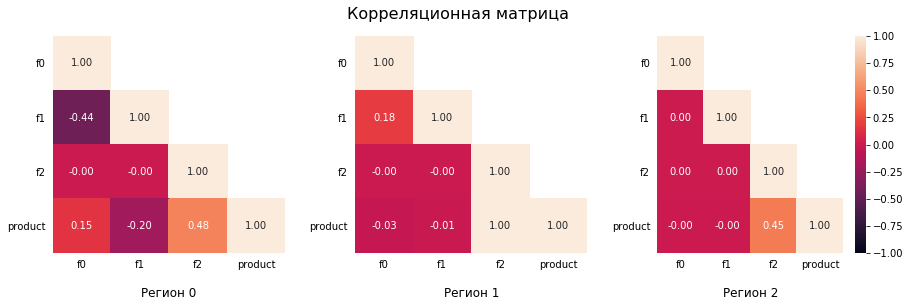

In [25]:
plot_corr_matrix([data.corr() for data in train_data], figsize=(15,4))

* В выборке нет линейно зависимых признаков. Отрицательная корреляция наблюдается между признаками `f0` и `f1` в регионе 0.
* Во всех регионах наибольшая корреляция с целевым признаком у признака `f2`, причём, в регионе 1 они линейно зависимы $\to$ имеет смысл обучить обычную линейную регрессию.

Возможно, связь между признаками нелинейная — изучим её подробнее.

## Регион 0

Построим диаграммы рассеяния.

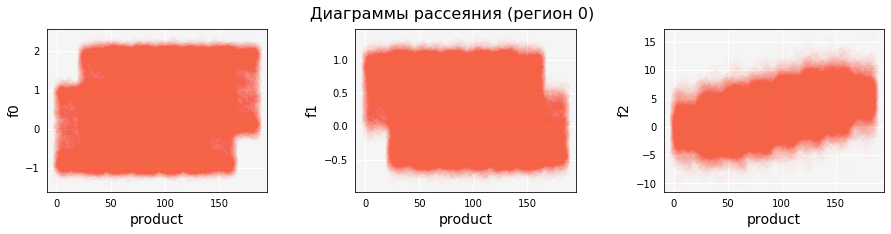

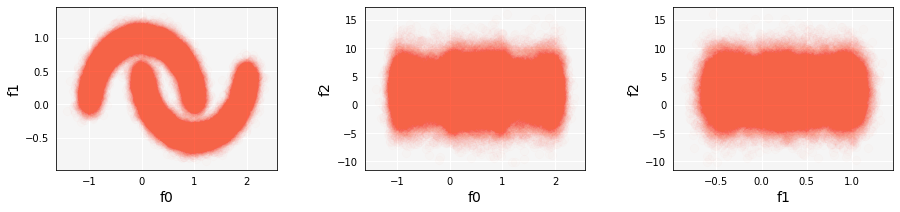

In [26]:
pairs = [list(cols) for cols in combinations(['product','f0','f1','f2'], r=2)]
for i in [0,1]:
    pair = [pairs[i*3 + j] for j in [0,1,2]]
    plot_scatter(
        [train_data[0][cols] for cols in pair], figsize=(15, 3), xlabels=[cols[0] for cols in pair],
        ylabels=[cols[1] for cols in pair], title='Диаграммы рассеяния (регион 0)' * (i==0)
    )

Связь с таргета с `f2` окололинейна, с `f0, f1` она устроена более сложно. Отчётливо видно, что в пространстве (`f0, f1`) объекты разделяются на два кластера. Вероятно, добавление вы выборку метки кластера, к которому принадлежит объект, позволит точнее предсказывать таргет.

Кластеры довольно плотные и визуально хорошо разделимы, поэтому для кластеризации выберем алгоритм *DBSCAN*. Обучим его на признаках `'f0', 'f1` из обучающей выборки.

In [27]:
cluster_data = train_data[0][['f0','f1']].copy()
dbscan = DBSCAN(min_samples=20, eps=0.04)
dbscan.fit(cluster_data)
cluster_data['label'] = dbscan.labels_

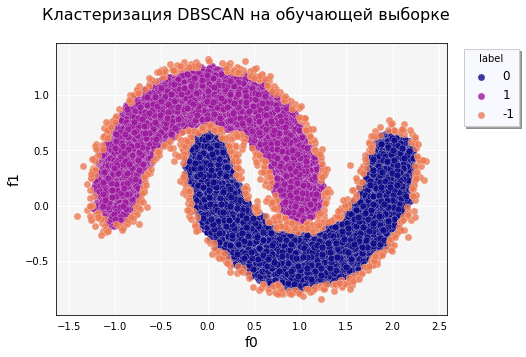

In [28]:
plot_scatter_labeled(cluster_data, ['f0','f1','label'],  'Кластеризация DBSCAN на обучающей выборке')

Кластеризация получилась довольно хорошая :)  
В классе *DBSCAN* нет метода `predict()`, поэтому, чтобы кластеризвать объекты и в обучающей, и в тестовой выборке, обучим классификатор *KNeighborsClassifier* на центральных образцах (*core samples*), выделенных *DBSCAN*. 

In [29]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])
train_data[0]['label'] = knn.predict(train_data[0][['f0','f1']])
test_data[0]['label'] = knn.predict(test_data[0][['f0','f1']])

Метка кластера сохранена в столбце `label`. Посмотрим, что получилось на обучающей выборке.

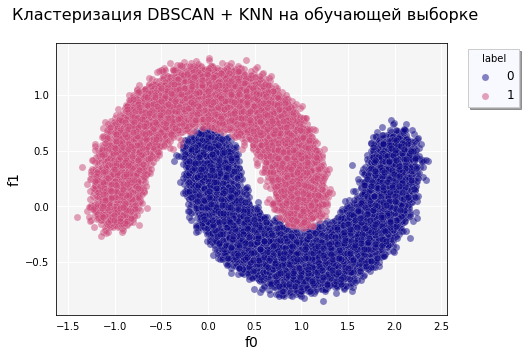

In [30]:
plot_scatter_labeled(train_data[0], ['f0','f1','label'], 'Кластеризация DBSCAN + KNN на обучающей выборке', 0.5)

Кластеры действительно разделились :) Посмотрим, связан ли новый признак признак `label` с таргетом.

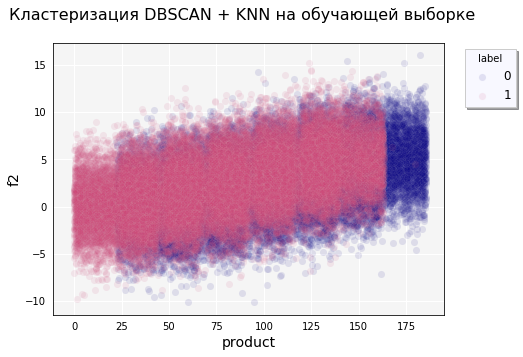

count    min    mean     50%     max
label                                         
1     37592.000  0.000  81.414  81.225 179.784
0     37408.000 22.316 103.757 103.949 185.364

In [31]:
plot_scatter_labeled(train_data[0], ['product','f2','label'], 
                     'Кластеризация DBSCAN + KNN на обучающей выборке', 0.1)
train_data[0].groupby('label')['product'].describe()[['count','min','mean','50%','max']].sort_values(by='50%')

Из графика видно, что запасы на скважинах с `label = 0` в среднем выше — признак информативен.

## Регион 1

Снова изучим диаграммы рассеяния.

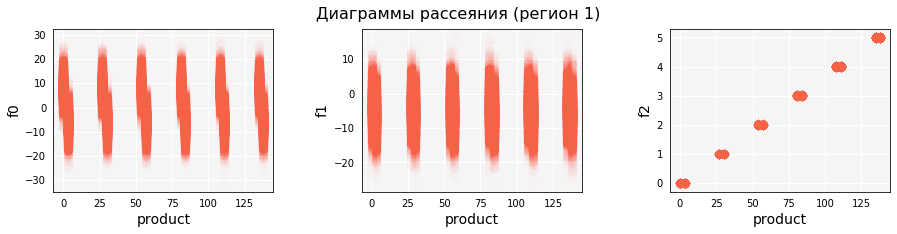

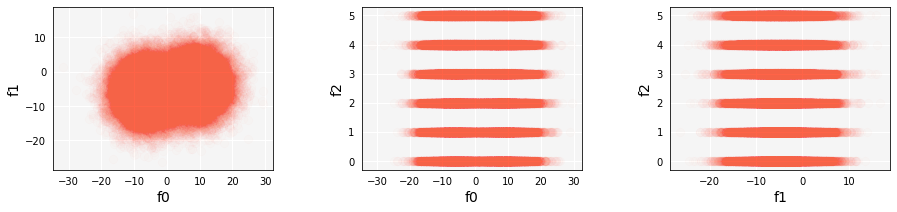

In [32]:
for i in [0,1]:
    pair = [pairs[i*3 + j] for j in [0,1,2]]
    plot_scatter(
        [train_data[1][cols] for cols in pair], figsize=(15, 3), xlabels=[cols[0] for cols in pair],
        ylabels=[cols[1] for cols in pair], title='Диаграммы рассеяния (регион 1)' * (i==0)
    )

В регионе 1 целевой признак принимает 12 дискретных значений. Из третьего графика видно, что по значениям `f_2` объекты хорошо разделяются на 6 пар кластеров. Чтобы разделить объекты внутри каждой пары, можно использовать значения признаков `f_0` и `f_1` — на графиках `product(f_0)` и `product(f_1)` видно, что они разделимы. 

Итак, сначала кластеризуем объекты по значениям `f2`. Поскольку кластеры линейно разделимы, будем использовать алгоритм *GaussianMixture*. Зададим число кластеров `n_components=6`, обучим модель на обучающей выборке и сохраним в столбце `label_f2` предсказания на обучающей и тестовой выборках.

In [33]:
gm = GaussianMixture(n_components=6, random_state=42).fit(train_data[1][['f2']])
train_data[1]['label_f2'] = gm.predict(train_data[1][['f2']])
test_data[1]['label_f2'] = gm.predict(test_data[1][['f2']])

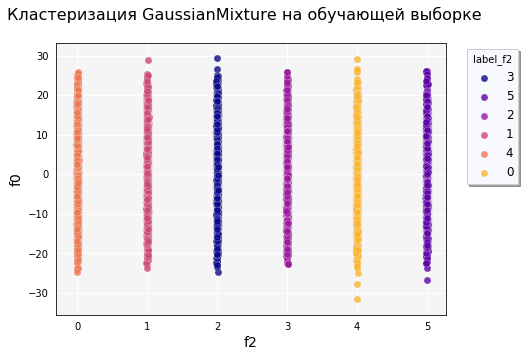

In [34]:
plot_scatter_labeled(train_data[1], ['f2','f0','label_f2'], 'Кластеризация GaussianMixture на обучающей выборке')

Кластеры получилось разделить :)

Теперь разделим объекты по значениям `f0` и `f1` на 2 кластера. Сохраним предсказания в столбце `label_f01`.

In [35]:
gm = GaussianMixture(n_components=2, random_state=42).fit(train_data[1][['f0','f1']])
train_data[1]['label_f01'] = gm.predict(train_data[1][['f0','f1']])
test_data[1]['label_f01'] = gm.predict(test_data[1][['f0','f1']])

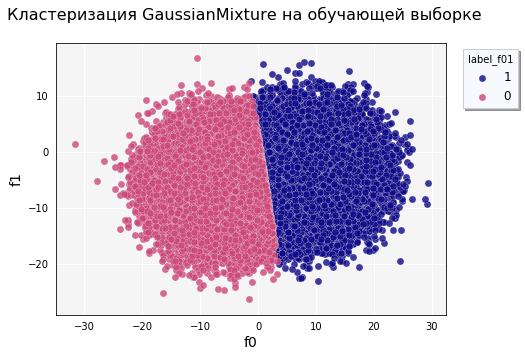

In [36]:
plot_scatter_labeled(train_data[1], ['f0','f1','label_f01'],'Кластеризация GaussianMixture на обучающей выборке')

Оценить качество кластеризации здесь сложнее, т.к. кластеры пересекаются.

Теперь создадим признак `label` — метку одного из 12 кластеров.

In [37]:
train_data[1]['label'] = train_data[1].apply(
    lambda row: str(int(row['label_f01'])) + '_' + str(int(row['label_f2'])), axis=1)
test_data[1]['label'] = test_data[1].apply(
    lambda row: str(int(row['label_f01'])) + '_' + str(int(row['label_f2'])), axis=1)

In [38]:
train_data[1] = train_data[1].drop(columns=['label_f01', 'label_f2'])
test_data[1] = test_data[1].drop(columns=['label_f01', 'label_f2'])

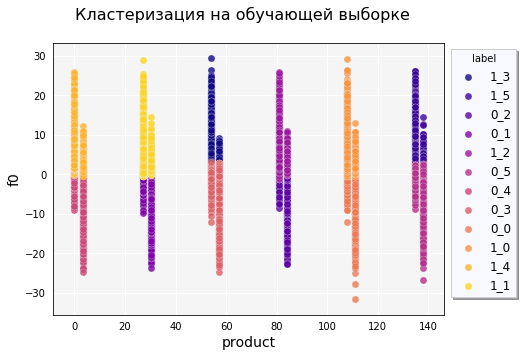

count     min    mean     50%     max
label                                         
1_4   6215.000   0.000   0.216   0.000   3.179
0_4   6202.000   0.000   2.978   3.179   3.179
1_1   6401.000  26.953  27.159  26.953  30.132
0_1   6171.000  26.953  29.924  30.132  30.132
1_3   6289.000  53.907  54.117  53.907  57.086
0_3   6336.000  53.907  56.861  57.086  57.086
1_2   6252.000  80.860  81.070  80.860  84.039
0_2   6340.000  80.860  83.828  84.039  84.039
1_0   6188.000 107.813 108.021 107.813 110.992
0_0   6194.000 107.813 110.804 110.992 110.992
1_5   6191.000 134.766 134.971 134.766 137.945
0_5   6221.000 134.766 137.721 137.945 137.945

In [39]:
plot_scatter_labeled(train_data[1], ['product','f0','label'],  'Кластеризация на обучающей выборке')
train_data[1].groupby('label')['product'].describe()[['count','min','mean','50%','max']].sort_values(by='50%')

Видим, что разделение получилось неидеальным из-за наложения кластеров в пространсте (`f0,f1`), тем не менее, запасы нефти в скважинах с различными значениями `label` отличаются — признак информативен. 

## Регион 2
Осталось рассмотреть последний регион.

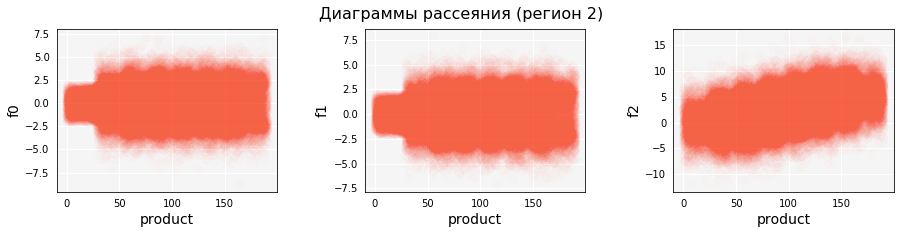

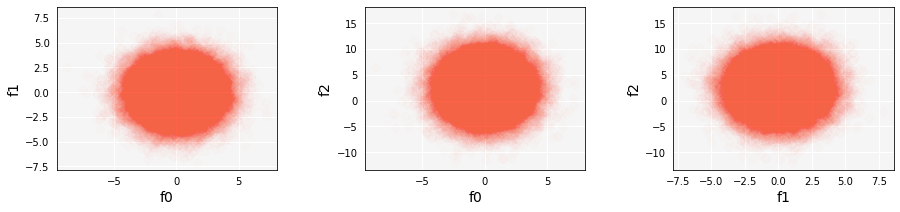

In [40]:
for i in [0,1]:
    pair = [pairs[i*3 + j] for j in [0,1,2]]
    plot_scatter(
        [train_data[2][cols] for cols in pair], figsize=(15, 3), xlabels=[cols[0] for cols in pair],
        ylabels=[cols[1] for cols in pair], title='Диаграммы рассеяния (регион 2)' * (i==0)
    )

Снова видим окололинейную зависимость таргета от `f2` и более сложную связь с `f0` и `f1`. Объекты на графиках визуально не разделяются на кластеры.

Более подробный анализ показал, что имеет смысл разделить объекты на два кластера по значениям признаков `f0` и `f1` на два кластера с разделяющей кривой в форме окружности с центром в точке (0,0) и радиусом 2.5 (см. графики `f0(product)` и `f1(product)`).

In [41]:
train_data[2]['label'] = train_data[2].apply(lambda row: (row['f0']**2 + row['f1']**2 < 2.5**2) * 1, axis=1)
test_data[2]['label'] = test_data[2].apply(lambda row: (row['f0']**2 + row['f1']**2 < 2.5**2) * 1, axis=1)

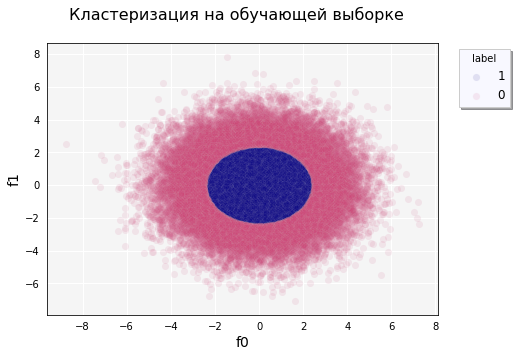

In [42]:
plot_scatter_labeled(train_data[2], ['f0','f1','label'],  'Кластеризация на обучающей выборке', 0.1)

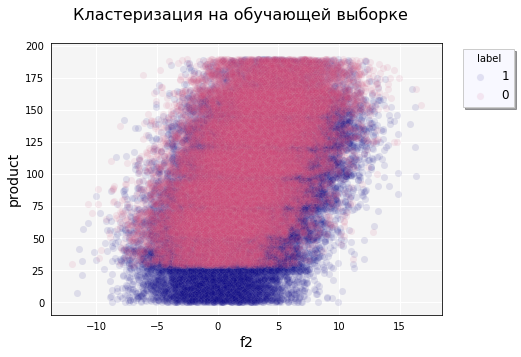

count    min    mean     50%     max
label                                         
0     26408.000 28.844 109.285 108.778 190.030
1     48592.000  0.000  87.159  86.666 189.988

In [43]:
plot_scatter_labeled(train_data[2], ['f2','product','label'],  'Кластеризация на обучающей выборке', 0.1)
train_data[2].groupby('label')['product'].describe()[['count','min','mean','50%','max']]

Видим, что признак `label` информативен :)

### Вывод <a class="tocSkip">
Анализ данных выявил следующие особенности:
* Все признаки в выборке линейно независимы.
* Во всех регионах наибольшая корреляция с таргетом у признака `f2`. Связь с `f0` и `f1` менее сильная, однако тоже присутствует. 
* Во всех регионах была проведена кластеризация объектов, в выборку добавлена метка кластера, к которому принадлежит скважина, — `label`. Показано, что этот признак связан с объёмом запасов в скважине и, следовательно, может быть полезен при обучении модели.

# Обучение модели 
[к оглавлению](#start)

Итак, перед нами задача регрессии. Метрика качества — MSE.  

Отделим матрицы объекты-признаки от целевых признаков.

In [44]:
x_train = [data.drop(columns=['product']) for data in train_data]
y_train = [data['product'] for data in train_data]
x_test = [data.drop(columns=['product']) for data in test_data]
y_test = [data['product'] for data in test_data]

Подготовим *pipeline* модели. Он будет включать кодирование признака `label`, добавление признаков 2 и выше порядков, масштабирование и обучение модели.

In [45]:
cat_encoder = ColumnTransformer(remainder='passthrough', transformers=[
    ('encoder', OneHotEncoder(drop='first', categories='auto', sparse=False), ['label']),
])
preprocessor = Pipeline(steps=[
    ('cat_encoder', cat_encoder),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', None)
])

### Константная модель <a class="tocSkip">

In [46]:
def get_cv_scores(true, pred):
    scores = pd.Series({
        'RMSE': mean_squared_error(true, pred)**0.5,
        'MAE': mean_absolute_error(true, pred),
        'R2': r2_score(true, pred),
        'max_error': max_error(true, pred)
    })
    return scores

In [47]:
scores = pd.DataFrame(columns=['Регион','Модель','RMSE','MAE','R2','max_error']).set_index(['Регион','Модель'])
for i in [0,1,2]:
    pred_constant = pd.Series([y_train[i].mean()] * len(y_test[i]))
    scores.loc[('Регион ' + str(i), 'Константная модель'),] = get_cv_scores(y_test[i], pred_constant)
scores

RMSE    MAE     R2 max_error
Регион   Модель                                           
Регион 0 Константная модель 44.277 37.648 -0.000    92.798
Регион 1 Константная модель 45.945 40.304 -0.000    69.087
Регион 2 Константная модель 44.783 37.830 -0.000    95.062

Среднеквадратичная ошибка довольно большая.

## Подбор гиперпараметров

Поскольку для компании важно, чтобы модель была интерпретируемой, будем обучать линейную регрессию. Для каждого региона подберём оптимальные гиперпараметры: степень `PolynomialFeatures`, тип масштабирования, тип и коэффициент регуляризации. Кодировать категориальные признаки будем техникой *OHE*, т.к. применять порядковое кодирование для линейной регрессии некорректно. Оценивать качество будем на кросс-валидации на 3 фолда.

In [48]:
parameters_grid = {
    'preprocessor__poly__degree': [3], # np.arange(1,6)
    'preprocessor__scaler': [StandardScaler(), MinMaxScaler()],
    'model': [Ridge(random_state=42), Lasso(random_state=42)],
    'model__alpha': [10**i for i in [-2.5,-1.5]]
}
gs = GridSearchCV(pipeline, parameters_grid, cv=3, scoring='neg_mean_squared_error')
gs_results = {}
for i in [0,1,2]:
    gs.fit(x_train[i], y_train[i])
    gs_results['Регион ' + str(i)] = gs.best_params_
    gs_results['Регион ' + str(i)]['score'] = (-gs.best_score_)**0.5
cv_scores_lr = pd.DataFrame(gs_results).T
cv_scores_lr

model model__alpha  \
Регион 0  Lasso(alpha=0.0031622776601683794, copy_X=True...        0.032   
Регион 1  Ridge(alpha=0.03162277660168379, copy_X=True, ...        0.032   
Регион 2  Lasso(alpha=0.0031622776601683794, copy_X=True...        0.003   

         preprocessor__poly__degree  \
Регион 0                          3   
Регион 1                          3   
Регион 2                          3   

                                       preprocessor__scaler  score  
Регион 0  StandardScaler(copy=True, with_mean=True, with... 37.028  
Регион 1  StandardScaler(copy=True, with_mean=True, with...  0.706  
Регион 2      MinMaxScaler(copy=True, feature_range=(0, 1)) 37.740

В таблице содержатся подобранные гиперпараметры и *RMSE* лучшей модели для каждого региона.  
Видим, что качество всех моделей лучше по сравнению с константной. Наиболее точные предсказания даёт модель в регионе 1. Это неудивительно: на этапе анализа данных мы видели, что в этом регионе таргет практически линейно зависим от одного из признаков.

## Обучение лучшей модели

Теперь обучим для каждого региона модель с оптимальными гиперпараметрами и найдём предсказания на тестовой выборке.

In [49]:
pipelines = []
pipelines.append(pipeline.set_params(
    preprocessor = preprocessor.set_params(poly__degree = 5, scaler = StandardScaler()),
    model = Lasso(random_state=42, alpha=10**(-1.5))
))
pipelines.append(pipeline.set_params(
    preprocessor = preprocessor.set_params(poly__degree = 3, scaler = StandardScaler()),
    model = Ridge(random_state=42, alpha=10**(-1.5))
))
pipelines.append(pipeline.set_params(
    preprocessor = preprocessor.set_params(poly__degree = 3, scaler = MinMaxScaler()),
    model = Lasso(random_state=42, alpha=10**(-2.5))
))

In [50]:
predictions = []
weights = []
for i in [0,1,2]:    
    pipe = pipelines[i]
    predictions.append(pd.Series(pipe.fit(x_train[i], y_train[i]).predict(x_test[i]), index=x_test[i].index))
    
    ohe_cols = list(pipelines[i]['preprocessor'][0].transformers_[0][1].get_feature_names(['label']))
    poly_cols = list(pipelines[i]['preprocessor'][1].get_feature_names(ohe_cols + ['f0','f1','f2']))
    w = pd.DataFrame(pipelines[i]['model'].coef_, index=poly_cols, columns=['weight'])
    w.loc['intercept'] = pipelines[i]['model'].intercept_
    weights.append(w.loc[w.abs().sort_values(by='weight', ascending=False).index])

Оценим качество моделей на тестовой выборке.

In [51]:
for i in [0,1,2]:
    scores.loc[('Регион ' + str(i), 'Обученная модель'),] = get_cv_scores(y_test[i], predictions[i])
scores.sort_values(by='Регион')

RMSE    MAE     R2 max_error
Регион   Модель                                           
Регион 0 Константная модель 44.277 37.648 -0.000    92.798
         Обученная модель   37.121 30.532  0.297   118.465
Регион 1 Константная модель 45.945 40.304 -0.000    69.087
         Обученная модель    0.755  0.433  1.000     3.231
Регион 2 Константная модель 44.783 37.830 -0.000    95.062
         Обученная модель   37.832 31.258  0.286   125.241

Все модели вменяемы: качество лучше, чем у константной. У всех качество сравнимо с оценкой на кросс-валидации.

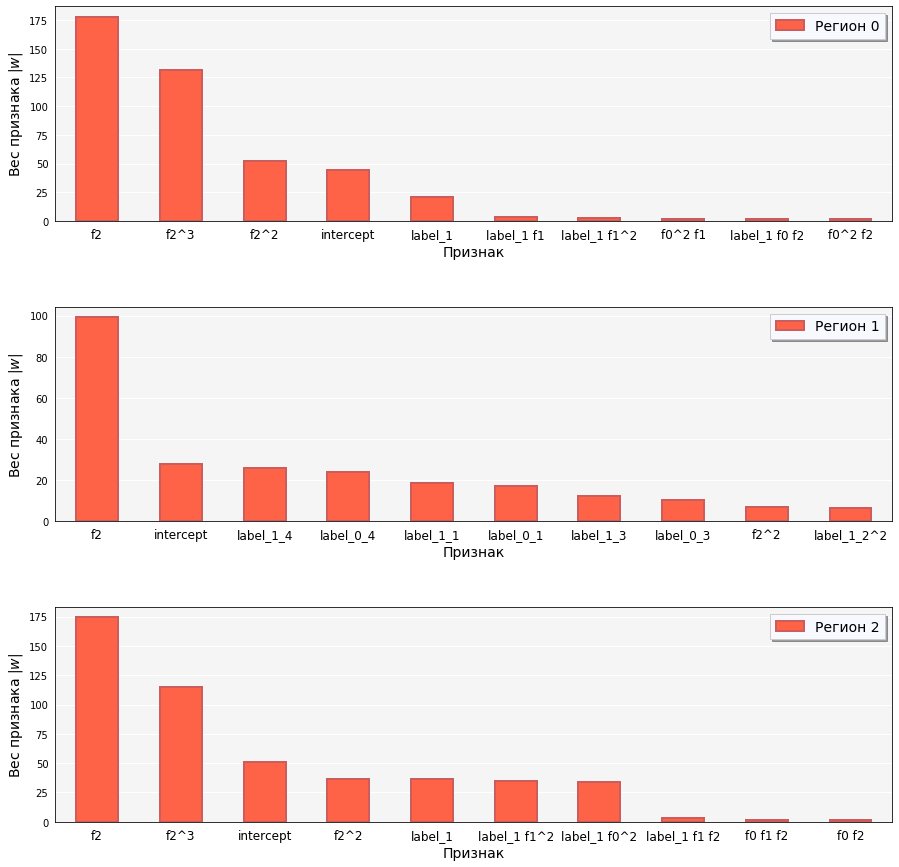

In [52]:
plot_bar([w['weight'].abs().head(10) for w in weights], ['Признак'] * 3)

Во всех трёх регионах наболее значимым признаком является `f2` и его комбинации. Это кажется вполне логичным, т.к. на этапе анализа данных мы видели, что этот признак сильнее других коррелирует с таргетом. Добавленный признак `label` также в топе по значимости во всех регионах.  
В регионе 1 значительно больше признаков с относительно большими весами. Это связано с тем, что эта модель в принципе обучалась на большем числе признаков. Кроме того, в отличие от двух других моделей здесь применялась гребневая регуляризация, которая более 'мягко' влияет на веса, чем лассо-регуляризация.

### Вывод  <a class="tocSkip">

Таким образом, для каждого региона была обучена модель, с хорошей точностью предсказывающая объём запасов нефти по данным о качестве нефти в скважине. Оптимальные гиперпараметры и качество моделей:

| Регион | Кодировка | Добавление признаков | Масштабирование | Регуляризация | $RMSE$ | $R^2$ |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 0 | OHE| `label` и признаки 2 — 3 порядка | StandardScaler | $\ell_1$-регуляризация с $C=10^{-1.5}$ | 37.121 | 0.297 |
| 1 | OHE | `label` и признаки 2 — 3 порядка | StandardScaler | $\ell_2$-регуляризация с $C=10^{-1.5}$ | 0.755 | 1.000 |
| 2 | OHE | `label` и признаки 2 — 3 порядка | MinMaxScaler | $\ell_1$-регуляризация с $C=10^{-2.5}$ | 37.832 | 0.286 |

Лучшее качество у модели для региона 1, что объясняется сильной корреляцией одного из признаков с таргетом.

# Расчёт прибыли и рисков
[к оглавлению](#start)

По результатам исследования скважины в регионе 2 содержат наибольшую среднюю концентрацию продукта, при этом качество модели для этого региона наихудшее. С другой стороны, в регионе 1 запасы нефти самые маленькие, но точность предсказаний для него на порядок выше. Интересно проанализировать, какой регион окажется наиболее перспективным для развития :)

Для начала вычислим достаточный объём сырья для безубыточной разработки новой скважины и сравним со средним запасом в каждом регионе.

In [53]:
print('Объём сырья для безубыточной разработки скважины (тыс. баррелей): {:.3f}'.format(
      COSTS / REVENUE_PER_THSD_BARREL / WELLS_TO_MINE_PER_REGION))
mean_product = pd.DataFrame(
    {'Регион ' + str(i): y_test[i].mean() for i in [0,1,2]}, 
    index=['Средние запасы сырья на одной скважине (тыс. баррелей)'])
mean_product.T

Объём сырья для безубыточной разработки скважины (тыс. баррелей): 111.111


Средние запасы сырья на одной скважине (тыс. баррелей)
Регион 0                                             92.326     
Регион 1                                             68.725     
Регион 2                                             95.151

Во всех трёх регонах средние запасы сырья на скважинах меньше необходимого минимума. Следовательно, если скважины в регионе будут выбираться случайным образом, добыча, вероятно, будет убыточной.  
Для проверки оценим техникой *bootstrap* выручку компании и риск убытков при разработке случайных скважин.

In [54]:
def count_revenue(true, pred):
    """ Функция для расчёта прибыли по скважинам с наивысшим предсказанным объёмом сырья """
    pred_sorted = pred.sort_values(ascending=False)
    selected = true[pred_sorted.index][:WELLS_TO_MINE_PER_REGION]
    return REVENUE_PER_THSD_BARREL * selected.sum()

In [55]:
def count_revenue_bootstrap(true, pred=None, how='random'):
    """ Функция для оценки прибыли компании техникой bootstrap """
    state = np.random.RandomState(42)
    revenue = []
    for j in range(1000):
        if how == 'random':
            target_sample = true.sample(WELLS_TO_MINE_PER_REGION, random_state=state, replace=True)
            revenue.append(target_sample.sum() * REVENUE_PER_THSD_BARREL)
        elif how == 'best':
            target_sample = true.sample(WELLS_TO_EXPLORE_PER_REGION, random_state=state, replace=True)
            pred_sample = pred[target_sample.index]
            revenue.append(count_revenue(target_sample, pred_sample))
    return pd.Series(revenue)

In [56]:
def count_revenue_risk(revenue_bs):
    """ Функция для расчёта выручки, прибыли, 95% доверительного интервала прибыли 
    и риска убытков компании, исходя из результатов bootstrap """
    conf_interv = (revenue_bs.quantile(LOSS_PROBABILITY)-COSTS, revenue_bs.quantile(1-LOSS_PROBABILITY)-COSTS)
    result = pd.Series({
        'Средняя выручка (млрд. руб.)': revenue_bs.mean() / 1e9 ,
        'Средняя прибыль (млрд. руб.)': (revenue_bs.mean() - COSTS) / 1e9,
        '0.025-квантиль прибыли (млрд. руб.)':  conf_interv[0] / 1e9,
        '0.975-квантиль прибыли (млрд. руб.)':  conf_interv[1] / 1e9,
        'Риск убытков (%)': st.percentileofscore(revenue_bs, COSTS)
    }) 
    return result

In [57]:
df_comparison_random = pd.DataFrame({
    'Регион ' + str(i): count_revenue_risk(count_revenue_bootstrap(y_test[i], how='random')) for i in [0,1,2]
})
df_comparison_random

Регион 0  Регион 1  Регион 2
Средняя выручка (млрд. руб.)            8.309     6.191     8.570
Средняя прибыль (млрд. руб.)           -1.691    -3.809    -1.430
0.025-квантиль прибыли (млрд. руб.)    -2.210    -4.418    -1.960
0.975-квантиль прибыли (млрд. руб.)    -1.170    -3.254    -0.889
Риск убытков (%)                      100.000   100.000   100.000

Из таблицы видим, что во всех регионах при выборе скважин случайным образом, разработка будет убыточной с вероятностью 100%. При этом наименьшие убытки будут в регионе 2, поскольку в этом регионе средние запасы сырья на скважинах выше.

Проверим, увеличит ли ожидаемую прибыль компании применение машинного обучения для выбора скважин :)

In [58]:
df_comparison_ml = pd.DataFrame({
    'Регион ' + str(i): count_revenue_risk(count_revenue_bootstrap(y_test[i], predictions[i], how='best')) 
    for i in [0,1,2]
})
df_comparison = pd.concat([
    df_comparison_random, df_comparison_ml], axis=1, keys=['Случайные скважины', 'Лучшие скважины'])
df_comparison

Случайные скважины                    \
                                              Регион 0 Регион 1 Регион 2   
Средняя выручка (млрд. руб.)                     8.309    6.191    8.570   
Средняя прибыль (млрд. руб.)                    -1.691   -3.809   -1.430   
0.025-квантиль прибыли (млрд. руб.)             -2.210   -4.418   -1.960   
0.975-квантиль прибыли (млрд. руб.)             -1.170   -3.254   -0.889   
Риск убытков (%)                               100.000  100.000  100.000   

                                    Лучшие скважины                    
                                           Регион 0 Регион 1 Регион 2  
Средняя выручка (млрд. руб.)                 10.499   10.511   10.715  
Средняя прибыль (млрд. руб.)                  0.499    0.511    0.715  
0.025-квантиль прибыли (млрд. руб.)          -0.058    0.100    0.184  
0.975-квантиль прибыли (млрд. руб.)           1.024    0.941    1.261  
Риск убытков (%)                              3.800    0.900    0.300

Видим, что выбор скважин исходя из предсказаний модели значительно увеличивает среднюю прибыль компании и снижает риск убытков :)  
Для компании важно, чтобы риск убытков был менее 2.5%. Этому условию удовлетворяют регионы 1 и 2. Чтобы было легче выбрать наиболее перспективный регион из этих двух, визуализируем результаты расчётов. Построим столбчатую диаграмму прибыли компании и отметим на ней 95% доверительные интервалы. 

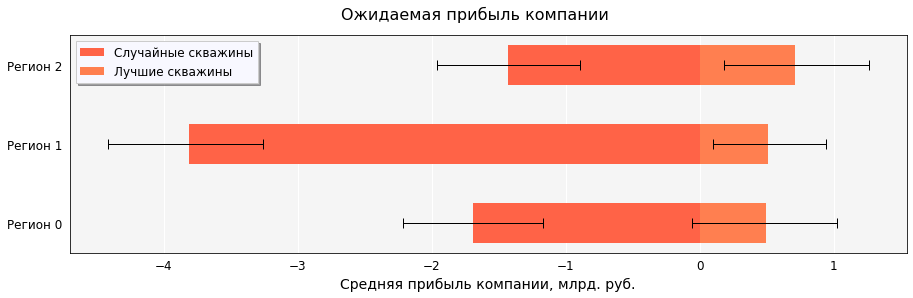

In [59]:
plot_revenue_bar(df_comparison)

С одной стороны, в регионе 1 произошло наиболее сильное увеличение прибыли, благодаря использованию ML для выбора скважин. Кроме того, доверительный интервал прибыли в этом регионе самый узкий. 

С другой стороны, наибольшая средняя прибыль компании ожидается в регионе 2, где больше запасы сырья на скважинах. Риск убытков в этом регионе также минимален. К тому же, точность модели в этом регионе далека от идеала — в перспективе можно повысить её качество и, следовательно, выбирать скважины с бОльшими запасами сырья. Качество модели для региона 1 уже близко к идеальной модели, и дальнейшее улучшение не приведёт к значительному увеличению прибыли компании.    

Исходя из всей совокупности факторов, можно сделать вывод, что наиболее перспективным для компании является регион 2.

# Общий вывод 
[к оглавлению](#start)

Исследование прибыли добывающей компании завершено.

1. Выполнена предобработка данных.
2. Проведён исследовательский анализ данных. Изучены распределения скважин по имеющимся признакам. Проанализированы взаимосвязи между признаками и их корреляция с таргетом.
3. Построены три модели машинного обучения, с хорошей точностью предсказывающие объём запасов нефти в скважинах трёх регионов по данным о качестве нефти. Подобраны оптимальные гиперпараметры, проанализированы сильные и слабые стороны моделей.

## Основные результаты:<a class="tocSkip">

### Предсказание объёма запасов в скважине<a class="tocSkip">

Для скважин каждого из трёх регионов обучена модель, предсказывающая объём запасов нефти.Поскольку для компании была важна предсказуемость результата, обучались простые интерпретируемые модели линейной регрессии. Все модели получились вменяемыми: их качество лучше, чем у константной.  
Оптимальные гиперпараметры и качество представлены в таблице (оценка качества на тестовой выборке):

| Регион | Кодировка | Добавление признаков | Масштабирование | Регуляризация | $RMSE$ | $R^2$ |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 0 | OHE| `label` и признаки 2 — 3 порядка | StandardScaler | $\ell_1$-регуляризация с $C=10^{-1.5}$ | 37.121 | 0.297 |
| 1 | OHE | `label` и признаки 2 — 3 порядка | StandardScaler | $\ell_2$-регуляризация с $C=10^{-1.5}$ | 0.755 | 1.000 |
| 2 | OHE | `label` и признаки 2 — 3 порядка | MinMaxScaler | $\ell_1$-регуляризация с $C=10^{-2.5}$ | 37.832 | 0.286 |

В выборки был добавлен новый признак `label` — метка кластера, к которому принадлежит скважина. Поскольку физический смысл признаков `f0, f1, f2` неизвестен, интерпретировать результаты кластеризации сложно. 

### Расчёт прибыли<a class="tocSkip">

1. Проведены расчёты ожидаемой прибыли и возможных рисков добычи нефти на случайно выбранных и рекомендованных моделью скважинах в трёх регионах. Результаты представлены в таблицах:

In [60]:
df_comparison

Случайные скважины                    \
                                              Регион 0 Регион 1 Регион 2   
Средняя выручка (млрд. руб.)                     8.309    6.191    8.570   
Средняя прибыль (млрд. руб.)                    -1.691   -3.809   -1.430   
0.025-квантиль прибыли (млрд. руб.)             -2.210   -4.418   -1.960   
0.975-квантиль прибыли (млрд. руб.)             -1.170   -3.254   -0.889   
Риск убытков (%)                               100.000  100.000  100.000   

                                    Лучшие скважины                    
                                           Регион 0 Регион 1 Регион 2  
Средняя выручка (млрд. руб.)                 10.499   10.511   10.715  
Средняя прибыль (млрд. руб.)                  0.499    0.511    0.715  
0.025-квантиль прибыли (млрд. руб.)          -0.058    0.100    0.184  
0.975-квантиль прибыли (млрд. руб.)           1.024    0.941    1.261  
Риск убытков (%)                              3.800    0.900    0.300

2. Наиболее перспективным для развития является регион 2, поскольку ожидаемая прибыль в нём наиболее высокая, а риск убытков минимален. Кроме того, на скважинах в этом регионе наиболее высокие средние запасы сырья.
3. Повышение точности предсказаний положительно сказывается на ожидаемой прибыли компании. Поэтому имеет смысл продолжить работу над улучшением качества моделей. 